In [1]:
#testing tfmodisco, it's actually modisco-lite
import numpy as np

In [3]:
a = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/ctst_bestepoch_100458_reg.npy')
print(a.shape)

(4, 1024, 161)


In [4]:
#seems modisco is better to use from the command line? I guess that's fine, let's first make the data that modisco can use
#so we somehow need to get the sequence, we have the ccre number and from there we can get the sequence
from shap_analysis.ism_utils import ISMUtils
ctst_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-25/15-41-13-286486/checkpoints/last.ckpt'
utils = ISMUtils('DNase_ctst', ctst_path, classification=True)

In [5]:
idx = 100458
a,b = utils.dataset[idx]
print(b)

(tensor([1]), tensor([1.5724]))


In [6]:
#it's classification and open, so there's 2 outputs only one input tho
print(a)

tensor([167,   7,   8,  ...,   8,   8,   8])


In [7]:
#The easiest way is to just untokenize a, but obviously that has problems
#the other way is to just grab the sequence directly
print(utils.dataset.tokenizer.decode(a[1:].numpy()))

ACCGCGCCCAGTGCCAACTTTGTCCTTCAACAGTTTGTGTGTGTGTGTGTGTGTGTGCGCGCCAGGCACAGTTGTAGGATCCAGCTCCACAGGTTCGGTGGGTTTTCTCTTTGTGTGCAGAGACAAGAGAGTGTAGAAATAAAGACACAAGACAGAGATAAAAGACAGCTGGGCCCGGGGAACCACTGCCACCTAGACGTGGAGACCGGTAGTGGCCCCGAGTGCCAGGCTGCGCTGTTATTTATTGGATACAAGACAAAGGGGCAGGATAAGGAGTGTGAGCCATCTCCAGTGATAGGTAAGGTCACGTGGGTCACGTGTCCACTGGACGGGGGCCCTTCCCTGCCTGGCAGCCGAGGCAGAGAGAGGGAGGGAGGGAGAGAGAGAGACAGCTTACGCCATTATTTCTGCTTATCAGAGACTTTTAGTACTTTCACTAATTTTGCTACTGTTATCTAAAAGGCAAAGCCAGGTGTACAGGATGGAACGTGAAGGCGGACTAGGAGTGTGACCGCTGAAGCACAGCATCACAGGGAGACGGTTAGGCCTTCGGATAACTGTGGGCGGGCCTGACCCTCCACAAGAGGTGGAGGAGTAGAGTCTTCTCTAAACTCCCCCGGGGAAAGGGAGACTCCCCTTCCCAGTCTGCTAAGTAGCGGGTGTTTTCCCTTGACACTGACGCTACCGCTAGACCACGGTCTGCTTAGGTCACGGGTGCCTTCCCAGGCGCTGGCGTTACTGCTAGACCAAGGAGCCCTCTGGTGGCCCTGTCCGGGCGTAACGGAAGGCTCGCACTCTTGTCTTCCGGTCGCTTCTCACTATGTCCCTTCAGCTCCTATCTCGGTATGGCCTGGTTTTTCCTAGATTATGATTATAGAGCGAGGATTATTATAATATTGGAATAAAGAGCAATTGCTACAAACTAATGATGAATGATATTCATATATAATCATATCTAAGATCTATATCTGGTATAACTATTCCTATTTTATATATTTTA

In [8]:
seq_idx = int(idx/161) #int will round down, equivalent to a//b for positive numbers

In [10]:
seq = utils.dataset.array[seq_idx,2]
print(seq.upper())
#this is much easier and will obviously be faster, let's just do this

ACCGCGCCCAGTGCCAACTTTGTCCTTCAACAGTTTGTGTGTGTGTGTGTGTGTGTGCGCGCCAGGCACAGTTGTAGGATCCAGCTCCACAGGTTCGGTGGGTTTTCTCTTTGTGTGCAGAGACAAGAGAGTGTAGAAATAAAGACACAAGACAGAGATAAAAGACAGCTGGGCCCGGGGAACCACTGCCACCTAGACGTGGAGACCGGTAGTGGCCCCGAGTGCCAGGCTGCGCTGTTATTTATTGGATACAAGACAAAGGGGCAGGATAAGGAGTGTGAGCCATCTCCAGTGATAGGTAAGGTCACGTGGGTCACGTGTCCACTGGACGGGGGCCCTTCCCTGCCTGGCAGCCGAGGCAGAGAGAGGGAGGGAGGGAGAGAGAGAGACAGCTTACGCCATTATTTCTGCTTATCAGAGACTTTTAGTACTTTCACTAATTTTGCTACTGTTATCTAAAAGGCAAAGCCAGGTGTACAGGATGGAACGTGAAGGCGGACTAGGAGTGTGACCGCTGAAGCACAGCATCACAGGGAGACGGTTAGGCCTTCGGATAACTGTGGGCGGGCCTGACCCTCCACAAGAGGTGGAGGAGTAGAGTCTTCTCTAAACTCCCCCGGGGAAAGGGAGACTCCCCTTCCCAGTCTGCTAAGTAGCGGGTGTTTTCCCTTGACACTGACGCTACCGCTAGACCACGGTCTGCTTAGGTCACGGGTGCCTTCCCAGGCGCTGGCGTTACTGCTAGACCAAGGAGCCCTCTGGTGGCCCTGTCCGGGCGTAACGGAAGGCTCGCACTCTTGTCTTCCGGTCGCTTCTCACTATGTCCCTTCAGCTCCTATCTCGGTATGGCCTGGTTTTTCCTAGATTATGATTATAGAGCGAGGATTATTATAATATTGGAATAAAGAGCAATTGCTACAAACTAATGATGAATGATATTCATATATAATCATATCTAAGATCTATATCTGGTATAACTATTCCTATTTTATATATTTTA

In [12]:
print(len(seq))
#so we need to cut off the last one to be correct, and need to cut off the first element of the numpy array too

1024


In [13]:
seq = seq[:-1].upper()
print(seq == utils.dataset.tokenizer.decode(a[1:].numpy()))

True


In [17]:
#now let's load in the numpy  array again
ism = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/ctst_bestepoch_100458_reg.npy')

In [18]:
ism.shape

(4, 1024, 161)

In [19]:
ism = ism[:,1:,:]
print(ism.shape)

(4, 1023, 161)


In [20]:
#This makes  sense now, we have them ligned up, let's sum
ismsum = np.sum(ism, axis=0)
ismsum.shape

(1023, 161)

In [21]:
#numyp is cool because that sum is identical to summing for each celltype separately then concatenating them together
#let's prove it
comparer = np.zeros((1023,161))
for celltype in range(161):
    comparer[:,celltype] = np.sum(ism[:,:,celltype], axis=0)
print(np.allclose(comparer, ismsum))

True


In [22]:
#The next step is to then use the one hot encoding to expand it back out
#so conceptually we make a function, it takes in the index, (make it part of ism utils)
#this index is then used to get the sequence, then we use the one hot encoding to expand it out, returns the one hot encoded shap values
#maybe we multiply it by -1?
#maybe it's easier to tokenize the sequence for one hot encoding?
mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
num_seq = np.array([mapping[nuc] for nuc in seq])
num_seq

array([0, 1, 1, ..., 1, 1, 1])

In [23]:
one_hot = np.zeros((len(seq), 4))
one_hot[np.arange(len(seq)), num_seq] = 1

# Expand dimensions
one_hot_expanded = np.repeat(one_hot[:, np.newaxis, :], 161, axis=1) #repeats for every single celltype which should be identical, that is true!

print(one_hot_expanded.shape)  # Should be (sequence_length, 161, 4)

(1023, 161, 4)


In [26]:
#nowo the one hot encoded matrix is
final = one_hot_expanded * ismsum[:,:,np.newaxis]
final.shape


(1023, 161, 4)

In [27]:
#this is a bit sus
final_out = np.transpose(final, (1,0,2))
print(final_out.shape)
#NxLx4. This is what they want, this is our attributions, the actual one hot is the one hot!

(161, 1023, 4)


In [28]:
onehot_final = np.transpose(one_hot_expanded, (1,0,2))
print(onehot_final.shape)

(161, 1023, 4)


In [36]:
#now we test this to see if it's correct, then we make it all a nice function we can add to the utils
#it returns the one hot encoded attributions, and the sequence, but the sequence is very easy to find I think?
#let's check by doing a for loop
for idx,i in enumerate(seq):
    print(i)
    n = mapping[i]
    print(n)
    # break
    print(np.allclose(final_out[:,idx,n], ismsum))
    print(np.allclose(final_out[:,idx,n+1], np.zeros(ismsum.shape)))
    print(np.allclose(final_out[:,idx,n+2], np.zeros(ismsum.shape)))
    print(np.allclose(final_out[:,idx,n+3], np.zeros(ismsum.shape)))
    # break
    if idx == 5:
        break

A
0
True
True
True
True
C
1
True
True
True


IndexError: index 4 is out of bounds for axis 2 with size 4

In [37]:
#now we test this to see if it's correct, then we make it all a nice function we can add to the utils
#it returns the one hot encoded attributions, and the sequence, but the sequence is very easy to find I think?
#let's check by doing a for loop
for idx,i in enumerate(seq):
    print(i)
    # n = mapping[i]
    # print(n)
    # break
    for n in range(4):
        if n == mapping[i]:
            print(np.allclose(final_out[:,idx,n], ismsum))
        else:
            print(np.allclose(final_out[:,idx,n], np.zeros(ismsum.shape)))
        # print(np.allclose(final_out[:,idx,n], ismsum))
    # print(np.allclose(final_out[:,idx,n], ismsum))
    # print(np.allclose(final_out[:,idx,n+1], np.zeros(ismsum.shape)))
    # print(np.allclose(final_out[:,idx,n+2], np.zeros(ismsum.shape)))
    # print(np.allclose(final_out[:,idx,n+3], np.zeros(ismsum.shape)))
    # break
    if idx == 5:
        break

A
True
True
True
True
C
True
True
True
True
C
True
True
True
True
G
True
True
True
True
C
True
True
True
True
G
True
True
True
True


In [38]:
#it seems good, let's just look at a random one
print(final_out[:,561,:])

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0.

In [40]:
#this doesn't seem right?
ismsum.mean() #oh, so the data is bad?

0.0

In [45]:
#now let's load in the numpy  array again
ism = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/ctst_bestepoch_100458_reg.npy')
# ism.shape
ism = ism[:,1:,:]
print(ism.shape)
#This makes  sense now, we have them ligned up, let's sum
# ismsum = np.sum(ism, axis=0)
# ismsum.shape
ism.max() #oh no... somethign is wrong with my ISM??

(4, 1023, 161)


0.0

In [46]:
ism = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/ctst_bestepoch_100458_class.npy')
ism.max() #wtf dude??

0.0

In [48]:
out = utils.calculate_ISM(100458, progress_bar=True)
print(out)

  0%|          | 5/1024 [01:04<3:40:07, 12.96s/it]


KeyboardInterrupt: 

In [65]:
import torch
from tqdm import tqdm
def calculate_ISM(utils,ccre, cuda = False, return_out = False, progress_bar = False, stop=False, b_size = 8):
    #does ISM for that ccre, based on the model type
    #Does what the ISM.py and ISM_allcelltypes.py files do but for one ccre at a time
    #ccre should be the index of the ccre, not the index to get that dataset
    # start = time.time()
    device = "cuda:0" if cuda else "cpu"
    backbone = utils.backbone.to(device)
    decoder = utils.decoder.to(device)
    #first have to load in the batch
    #if it's the different groups have very different dataset classes
    if utils.mtype == 'DNase' or utils.mtype == 'DNase_ctst':
        ccre = 161*ccre
        ccre_list = []
        # out_list = []
        # class_list = []
        for i in range(161):
            a,b = utils.dataset[ccre+i]
            ccre_list.append(a)
            # if utils.classification:
                # raise NotImplementedError('This is not implemented yet, need to consider how to do ISM with the classification model')
                # class_list.append(b[0].item())
                # b = b[1] #just ignore the classification stuff?
            # out_list.append(b.item())
        ccre_list = torch.stack(ccre_list)
    else:
        ccre_list = utils.dataset[ccre][0].unsqueeze(0)
        # class_list = utils.dataset[ccre][1][0] #the classification stuff
    # print(class_list)
    temp,_ = backbone(ccre_list.to(device)) #pass whole ccre as a batch
    out = decoder(temp)
    seqlen = ccre_list.shape[1] #because it's batch x seq
    dim_out = out.shape[1]//2
    #also a dimension for ccre_list.shape[0]
    dim_celltypes = ccre_list.shape[0]

    if utils.classification:
        out_class = out[:,:dim_out]
        out = out[:,dim_out:] #just ignore the classification stuff? for now maybe and we just look at the regression outputs?
        #but if it thinks that the thing is closed, we should keep it as 0... or maybe set it to some other value? idk
        #i say keep it but we know that we can mask it, no let's mask for reg, but still need to use for class...
        #and let's keep the class out
        #we can mask out the reg if needed using the actual outputs, if it's -10, ignore it maybe?
        out_class_gt = out_class.detach().reshape(1,1,161)
        ISM_class = torch.ones((4,seqlen,161)).to(device)*out_class_gt
        out_class_gt_np = out_class.detach().cpu().numpy().reshape(1,1,161)
        
    out_gt = out.detach().reshape(1,1,161)
    ISM_results = torch.ones((4,seqlen,161)).to(device)*out_gt
    out_gt_np = out.detach().cpu().numpy().reshape(1, 1, 161) #the initial output of the model before ism
    # if utils.classification:
    #     mask_idx = np.array(class_list) == 1 #if it's open
    #     #now we make this a matrix of the same size as the output which will be 3x1x161 or just 3x161
    #     mask = np.zeros((1,1,161))
    #     mask[:,:,mask_idx] = 1
    # print(mask)
    if utils.mtype == 'DNase' or utils.mtype == 'DNase_ctst': #we just need the first sequence, don't care about the useless stuff
        seq = ccre_list[0]
    else:
        seq = ccre_list.squeeze() #get rid f the embedding dimension
    token_list = [7,8,9,10] #tokenize this list first
    mutations = {
        7: np.array([8,9,10]),
        8: np.array([7,9,10]),
        9: np.array([7,8,10]),
        10: np.array([7,8,9])
    }
    ccre_list_gpu = ccre_list.to(device)

    if progress_bar:
        iterator = tqdm(enumerate(seq), total = len(seq))
    else:
        iterator = enumerate(seq)

    with torch.no_grad():
        for idx, nucleotide in iterator: 
            if nucleotide not in token_list:
                continue #basically skips this and none of it is updated, because is a weird tooken, whether permutation, ctst or something else
            temp_token_list = mutations[nucleotide.item()]
            class_list = []
            results_list = []
            for idx2,j in enumerate(temp_token_list):
                temp_seq = ccre_list_gpu.clone() #already put on the gpu
                # if utils.mtype in ['DNase', 'DNase_ctst']:
                #     temp_seq[:,idx] = j #should be 161x1024 or 1023. 
                # else:
                #     temp_seq[idx] = j #should be 1x1023 because we unsqueezed
                temp_seq[:,idx] = j
                a,_ = backbone(temp_seq)
                out = decoder(a)
                if utils.classification:
                    class_list.append(out[:,:dim_out].detach()) #161 x 1 if ctst, 1x161 if multitasking, squeeze fixes it
                    results_list.append(out[:,dim_out:].detach()) 
                else:
                    results_list.append(out.detach())

            ISM_results[temp_token_list-7,idx,:] = torch.stack(results_list).squeeze().to(device) #baasically turns to 3 x 1 x 161 or 3 x 161 x 1 then squeezes it
            if utils.classification:
                ISM_class[temp_token_list-7,idx,:] = torch.stack(class_list).squeeze().to(device)
            if idx == stop:
                break
    ISM_results_normalized = (ISM_results - out_gt).detach().cpu().numpy() #is mutated - reference
    if utils.classification:
        #first we do sigmoid then subtraction
        ISM_class = torch.sigmoid(ISM_class)
        out_class_gt = torch.sigmoid(out_class_gt)
        ISM_class_normalized = (ISM_class-out_class_gt).detach().cpu().numpy()
        # ISM_class_normalized = ISM_class.detach().cpu().numpy() - out_class_gt_np
        # ISM_results_normalized *= mask
    return ISM_results, ISM_results_normalized
    if utils.classification and return_out:
        return ISM_results_normalized, ISM_class_normalized, out_gt_np, out_class_gt_np
    elif utils.classification:
        return ISM_results_normalized, ISM_class_normalized 
    elif return_out: #but this is optional
        return ISM_results_normalized, out_gt_np
    return ISM_results_normalized


In [55]:
calculate_ISM(utils,100458, progress_bar=True, stop=5)

  0%|          | 5/1024 [01:14<4:12:14, 14.85s/it]


(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0

In [56]:
out = _55

In [57]:
len(out)

2

In [58]:
print(out[0].max(), out[1].max()) #ok this has some values

0.0 5.9604645e-08


In [60]:
calculate_ISM(utils,100458, progress_bar=True, stop=5)

  0%|          | 5/1024 [01:18<4:27:44, 15.77s/it]


(tensor([[[-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          ...,
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608]],
 
         [[-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          ...,
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608]],
 
         [[-1.0953, -0.9033, -1.0985,  ...,  0.2794, -1.2057,  0.2608],
          [-1.0953, -0.9033,

In [61]:
out = _

In [62]:
#now let's use out
print(out[0].shape, out[1].shape)

torch.Size([4, 1024, 161]) (4, 1024, 161)


In [63]:
out[0][:,0,:]
#this doesn't seem right, they are basically identical...

tensor([[-1.0953, -0.9033, -1.0985, -1.2926, -1.1869, -1.3746, -1.3686, -1.6711,
         -0.8178, -1.7881, -1.7721, -1.2936, -1.2839, -1.7666, -1.8064, -1.2948,
         -1.3464, -1.4567, -1.3754, -1.7457, -1.9006, -1.4890, -1.2441, -1.2342,
         -1.6415, -0.8010, -1.8154, -1.2156, -1.3096, -1.1948, -1.9905, -1.0546,
         -1.2037, -0.7955, -0.9358, -1.8273, -1.2665, -0.2426, -0.0292, -0.1344,
          0.0977, -0.0903,  0.0208,  0.0306,  0.0990,  0.3734,  0.4633,  0.2079,
         -0.4556,  0.1349,  0.2741, -0.9881, -0.4300, -0.9418, -0.4287, -0.8477,
         -0.5756,  0.1772, -0.3113, -0.0630, -0.2884, -0.1681, -0.2805,  0.1027,
         -0.0161,  0.5547, -0.4136,  0.1976,  0.1057,  0.3021, -0.3698, -0.4398,
          0.3197, -0.3958, -0.0670, -0.0550, -0.2022,  0.5733,  0.4317,  0.2082,
          0.0450,  0.0927, -0.1309, -0.6871,  0.3536,  0.5677, -0.9241,  0.2491,
         -0.0258, -0.7274,  0.2157,  0.2718,  0.2172,  0.4528,  0.8020, -0.2778,
          0.0891, -0.7843, -

In [64]:
out[0][0,0,:] #these are the 161 celltypes, but it seems identical for each nucleotide

tensor([-1.0953, -0.9033, -1.0985, -1.2926, -1.1869, -1.3746, -1.3686, -1.6711,
        -0.8178, -1.7881, -1.7721, -1.2936, -1.2839, -1.7666, -1.8064, -1.2948,
        -1.3464, -1.4567, -1.3754, -1.7457, -1.9006, -1.4890, -1.2441, -1.2342,
        -1.6415, -0.8010, -1.8154, -1.2156, -1.3096, -1.1948, -1.9905, -1.0546,
        -1.2037, -0.7955, -0.9358, -1.8273, -1.2665, -0.2426, -0.0292, -0.1344,
         0.0977, -0.0903,  0.0208,  0.0306,  0.0990,  0.3734,  0.4633,  0.2079,
        -0.4556,  0.1349,  0.2741, -0.9881, -0.4300, -0.9418, -0.4287, -0.8477,
        -0.5756,  0.1772, -0.3113, -0.0630, -0.2884, -0.1681, -0.2805,  0.1027,
        -0.0161,  0.5547, -0.4136,  0.1976,  0.1057,  0.3021, -0.3698, -0.4398,
         0.3197, -0.3958, -0.0670, -0.0550, -0.2022,  0.5733,  0.4317,  0.2082,
         0.0450,  0.0927, -0.1309, -0.6871,  0.3536,  0.5677, -0.9241,  0.2491,
        -0.0258, -0.7274,  0.2157,  0.2718,  0.2172,  0.4528,  0.8020, -0.2778,
         0.0891, -0.7843, -0.6089, -0.53

In [66]:
out = calculate_ISM(utils,100458, progress_bar=True, stop=5, return_out=True)

  0%|          | 5/1024 [01:16<4:21:05, 15.37s/it]


# redo the analysis but now with real ism results

In [4]:
#dude there's actually no way, we forgot to... oh no, we forgot to edit the things. let's check it now make sure it's not all zero
#let's try this
import numpy as np
from shap_analysis.ism_utils import ISMUtils
multitasking_path1 = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-27/18-39-11-031863/checkpoints/25-val_loss=0.52186.ckpt' #the 25 epoch one
a = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/multitasking_25epoch_174906_reg.npy')
utils = ISMUtils('DNase_allcelltypes', multitasking_path1, classification=True)
print(a.shape)

(4, 1023, 161)


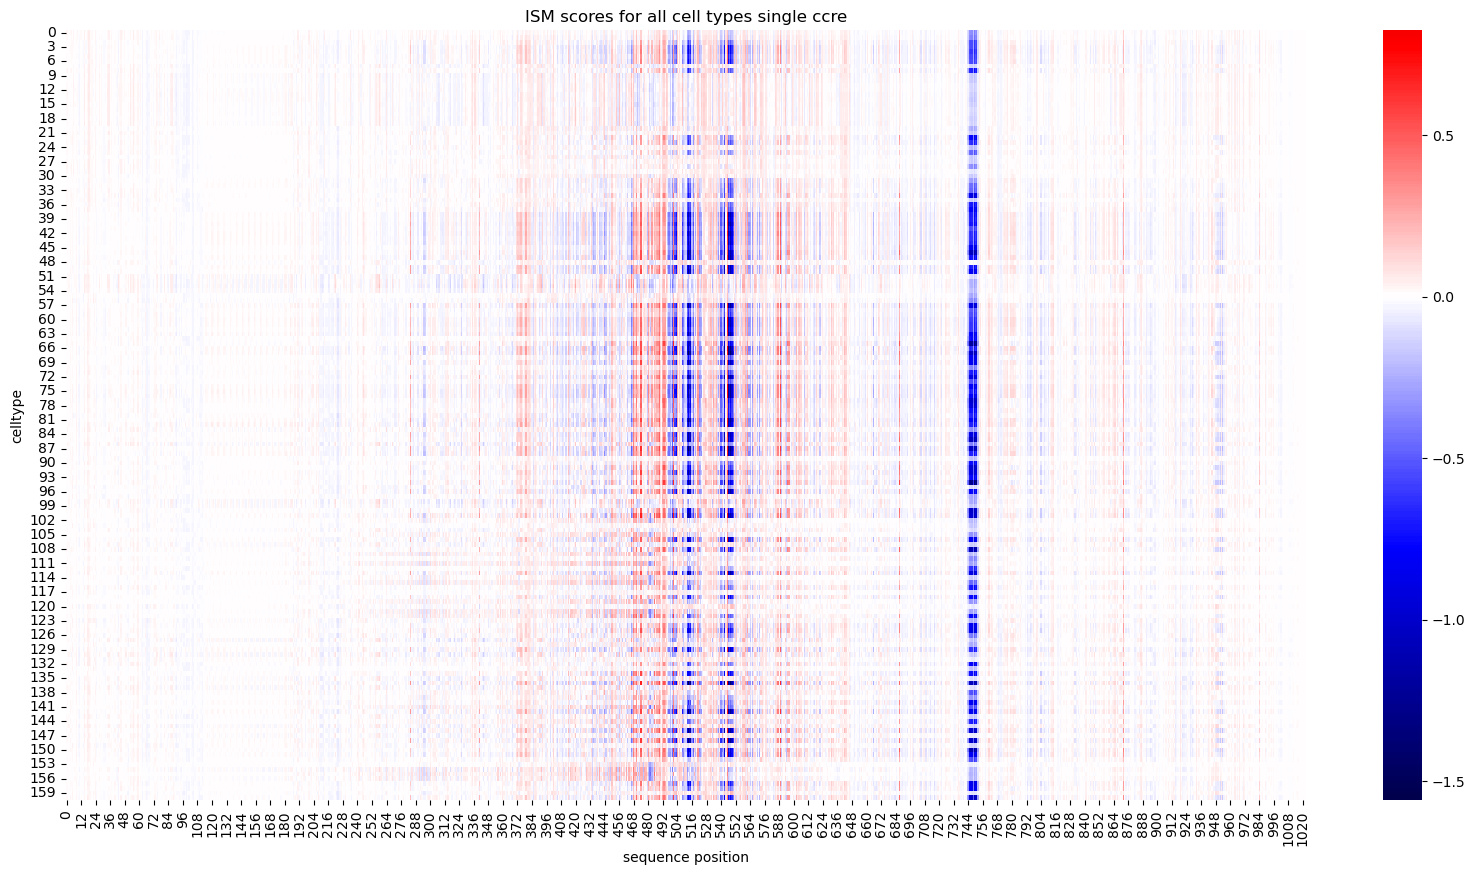

In [5]:
#now let's do a ISM plot of a
utils.plot_all(a)

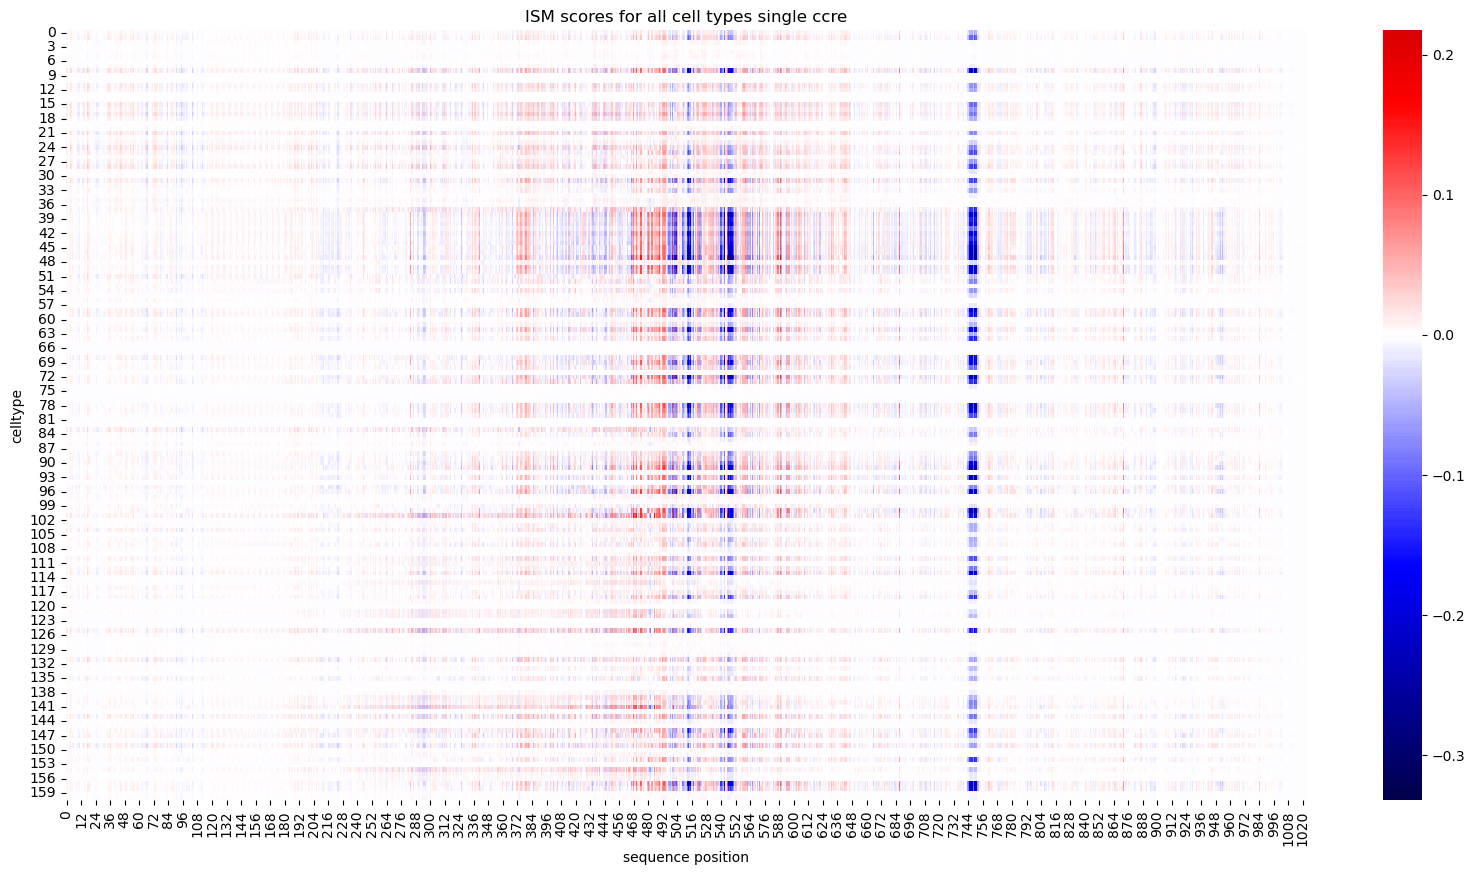

In [10]:
a = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/multitasking_25epoch_174906_class.npy')
utils.plot_all(a)

In [9]:
idx = 100458
a,b = utils.dataset[idx]
print(b)
#it's classification and open, so there's 2 outputs only one input tho
print(a)
#The easiest way is to just untokenize a, but obviously that has problems
#the other way is to just grab the sequence directly
print(utils.dataset.tokenizer.decode(a.numpy()))
seq_idx = idx #int will round down, equivalent to a//b for positive numbers
seq = utils.dataset.array[seq_idx,2]
print(seq.upper())
#this is much easier and will obviously be faster, let's just do this
print(len(seq))
#so we need to cut off the last one to be correct, and need to cut off the first element of the numpy array too
seq = seq[:-1].upper()
print(seq == utils.dataset.tokenizer.decode(a.numpy()))
ism = np.load(f'/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/multitasking_25epoch_{idx}_reg.npy')


(tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]), tensor([ -1.0963, -10.0000,  -1.3668,  -1.3098,  -1.1272, -10.0000,  -2.2439,
         -1.3879, -10.0000,  -0.8148,  -1.2118, -10.0000, -10.0000,  -1.4949,
         -1.1151,  -0.4080,  -0.9959,  -2.1763, -10.0000,  -1.0257,  -3.5240,
         -3.4929, -10.0000,  -0.4639, -10.0000, -10.0000,  -1.2266, -10.0000,
         -0.5059,   0.2123,  -1.3798, -10.0000,  -1.8971, -10.0000,  -0.6059,
         -1.9064,  -0.4771,  -0.6986,  -0.3585,   0.7449, -10.0000, 

In [11]:
#This makes  sense now, we have them ligned up, let's sum
ismsum = np.sum(ism, axis=0)
ismsum.shape

(1023, 161)

In [12]:
#numyp is cool because that sum is identical to summing for each celltype separately then concatenating them together
#let's prove it
comparer = np.zeros((1023,161))
for celltype in range(161):
    comparer[:,celltype] = np.sum(ism[:,:,celltype], axis=0)
print(np.allclose(comparer, ismsum))

True


In [13]:
#The next step is to then use the one hot encoding to expand it back out
#so conceptually we make a function, it takes in the index, (make it part of ism utils)
#this index is then used to get the sequence, then we use the one hot encoding to expand it out, returns the one hot encoded shap values
#maybe we multiply it by -1?
#maybe it's easier to tokenize the sequence for one hot encoding?
mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
num_seq = np.array([mapping[nuc] for nuc in seq])
num_seq

array([3, 1, 1, ..., 3, 3, 3])

In [14]:
one_hot = np.zeros((len(seq), 4))
one_hot[np.arange(len(seq)), num_seq] = 1

# Expand dimensions
one_hot_expanded = np.repeat(one_hot[:, np.newaxis, :], 161, axis=1) #repeats for every single celltype which should be identical, that is true!

print(one_hot_expanded.shape)  # Should be (sequence_length, 161, 4)

(1023, 161, 4)


In [15]:
#nowo the one hot encoded matrix is
final = one_hot_expanded * ismsum[:,:,np.newaxis]
final.shape


(1023, 161, 4)

In [16]:
#this is a bit sus
final_out = np.transpose(final, (1,0,2))
print(final_out.shape)
#NxLx4. This is what they want, this is our attributions, the actual one hot is the one hot!

(161, 1023, 4)


In [17]:
onehot_final = np.transpose(one_hot_expanded, (1,0,2))
print(onehot_final.shape)

(161, 1023, 4)


In [21]:
#now we test this to see if it's correct, then we make it all a nice function we can add to the utils
#it returns the one hot encoded attributions, and the sequence, but the sequence is very easy to find I think?
#let's check by doing a for loop
for idx,i in enumerate(seq):
    print(i)
    # n = mapping[i]
    # print(n)
    # break
    for n in range(4):
        if n == mapping[i]:
            print(np.allclose(final_out[:,idx,n], ismsum), 'actual')
        else:
            print(np.allclose(final_out[:,idx,n], np.zeros(ismsum.shape)))
        # print(np.allclose(final_out[:,idx,n], ismsum))
    # print(np.allclose(final_out[:,idx,n], ismsum))
    # print(np.allclose(final_out[:,idx,n+1], np.zeros(ismsum.shape)))
    # print(np.allclose(final_out[:,idx,n+2], np.zeros(ismsum.shape)))
    # print(np.allclose(final_out[:,idx,n+3], np.zeros(ismsum.shape)))
    # break
    if idx == 5:
        break

T
True
True
True
False actual
C
True
False actual
True
True
C
True
False actual
True
True
T
True
True
True
False actual
G
True
True
False actual
True
T
True
True
True
False actual


In [22]:
#let's try a different way to onehot encode
one_hot = np.zeros((161, len(seq), 4))
print(one_hot.shape)

(161, 1023, 4)


In [23]:
ismsum.shape

(1023, 161)

In [24]:
ismsumt = ismsum.T
print(ismsumt.shape)

(161, 1023)


In [25]:
#wait no it's better to not deal with this yet, then we just multiply it later
#so for now we'll start by doing ont hot encoding along the sequence to get 1023 x 4
one_hot = np.zeros((len(seq), 4))
one_hot[np.arange(len(seq)), num_seq] = 1
print(one_hot.shape)

(1023, 4)


In [29]:
print(num_seq[:15])

[3 1 1 3 2 3 1 1 1 3 2 0 2 1 0]


In [30]:
print(one_hot[:15,:])

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [31]:
#now repeat this one hot 161 times so it is 161 x 1023 x 4
one_hot_expanded = np.repeat(one_hot[np.newaxis,:,:], 161, axis=0)
print(one_hot_expanded.shape)

(161, 1023, 4)


In [33]:
#check if each row is the same as the next one
for i in range(161):
    temp = np.allclose(one_hot_expanded[i,:,:], one_hot)
    if temp is False:
        print(i)
        break

In [34]:
#now let's transpose ism sum
ismsumt = ismsum.T
print(ismsumt.shape)

(161, 1023)


In [35]:
ismsumt = ismsumt[:,:, np.newaxis]
print(ismsumt.shape)

(161, 1023, 1)


In [36]:
#now multiply them
final = one_hot_expanded * ismsumt
print(final.shape)

(161, 1023, 4)


In [41]:
#now let's do the check again
for idx,i in enumerate(seq):
    print(i)
    # n = mapping[i]
    # print(n)
    # break
    for n in range(4):
        # print(final[:,idx,n].shape)
        # print(ismsum[idx,:].shape)
        if n == mapping[i]:
            print(np.allclose(final[:,idx,n], ismsum[idx,:]), 'actual')
        else:
            print(np.allclose(final[:,idx,n], np.zeros(ismsum.shape[1])))
        # print(np.allclose(final_out[:,idx,n], ismsum))
    # print(np.allclose(final_out[:,idx,n], ismsum))
    # print(np.allclose(final_out[:,idx,n+1], np.zeros(ismsum.shape)))
    # print(np.allclose(final_out[:,idx,n+2], np.zeros(ismsum.shape)))
    # print(np.allclose(final_out[:,idx,n+3], np.zeros(ismsum.shape)))
    # break
    if idx == 5:
        break

T
True
True
True
True actual
C
True
True actual
True
True
C
True
True actual
True
True
T
True
True
True
True actual
G
True
True
True actual
True
T
True
True
True
True actual


In [46]:
def onehot_ism(utils, idx):
    # idx = 100458
    # a,b = utils.dataset[idx]
    if utils.mtype == 'DNase' or utils.mtype == 'DNase_ctst':
        seq_idx = int(idx/utils.cell_types)
        start = 1
    else:
        seq_idx = idx
        start = 0
    seq = utils.dataset.array[seq_idx,2]
    seq = seq[:-1].upper()
    # print(len(seq))
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    num_seq = np.array([mapping[nuc] for nuc in seq])
    one_hot = np.zeros((len(seq), 4))
    one_hot[np.arange(len(seq)), num_seq] = 1
    one_hot_expanded = np.repeat(one_hot[np.newaxis,:,:], 161, axis=0)
    ism = np.load(f'/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/multitasking_25epoch_{idx}_reg.npy')
    ism = ism[:,start:,:]
    ismsum = np.sum(ism, axis=0)
    ismsumt = ismsum.T
    ismsumt = ismsumt[:,:, np.newaxis]
    # print(ismsumt.shape)
    # print(one_hot_expanded.shape)
    final = one_hot_expanded * ismsumt
    return final, one_hot_expanded, seq

#here's what we test
#just test seq again and make sure it's what's input into both of the models
#make sure final and one_hot_expanded are what we expect
final2, one_hot_expanded2, seq2 = onehot_ism(utils, 100458)
print(np.allclose(final2, final), np.allclose(one_hot_expanded2, one_hot_expanded), seq2 == seq)

True True True


In [1]:
#dude there's actually no way, we forgot to... oh no, we forgot to edit the things. let's check it now make sure it's not all zero
#let's try this
import numpy as np
from shap_analysis.ism_utils import ISMUtils
ctst_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-25/15-41-13-286486/checkpoints/last.ckpt'
a = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/ctst_bestepoch_104866_reg.npy')
utils = ISMUtils('DNase_ctst', ctst_path, classification=True)
print(a.shape)

(4, 1024, 161)


In [2]:
ismsum = np.sum(a, axis=0)
print(ismsum.shape)

(1024, 161)


In [6]:
def onehot_ism(utils, idx, name):
    # idx = 100458
    # a,b = utils.dataset[idx]
    if utils.mtype == 'DNase' or utils.mtype == 'DNase_ctst':
        seq_idx = int(idx/161)
        start = 1
    else:
        seq_idx = idx
        start = 0
    seq = utils.dataset.array[seq_idx,2]
    seq = seq[:-1].upper()
    # print(len(seq))
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    num_seq = np.array([mapping[nuc] for nuc in seq])
    one_hot = np.zeros((len(seq), 4))
    one_hot[np.arange(len(seq)), num_seq] = 1
    one_hot_expanded = np.repeat(one_hot[np.newaxis,:,:], 161, axis=0)
    ism = np.load(f'/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/{name}_{idx}_reg.npy') #have to change this
    ism = ism[:,start:,:]
    # print(ism.shape)
    ismsum = np.sum(ism, axis=0)
    ismsumt = ismsum.T
    ismsumt = ismsumt[:,:, np.newaxis]
    # print(ismsumt.shape)
    # print(one_hot_expanded.shape)
    final = one_hot_expanded * ismsumt
    return final, one_hot_expanded, seq

#here's what we test
#just test seq again and make sure it's what's input into both of the models
#make sure final and one_hot_expanded are what we expect
final2, one_hot_expanded2, seq2 = onehot_ism(utils, 104866)
print(len(seq2))

1023


In [12]:
ismsum.shape
ismsum = ismsum[1:,:] #have to make it 1023 the same shape, ignore the first one
#else we're comparing including the one that doesn't have a one hot, that's obviously wrong

In [13]:
#now let's do the check again
mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
for idx,i in enumerate(seq2):
    print(i)
    # n = mapping[i]
    # print(n)
    # break
    for n in range(4):
        # print(final[:,idx,n].shape)
        # print(ismsum[idx,:].shape)
        if n == mapping[i]:
            print(np.allclose(final2[:,idx,n], ismsum[idx,:]), 'actual')
        else:
            print(np.allclose(final2[:,idx,n], np.zeros(ismsum.shape[1])))
        # print(np.allclose(final_out[:,idx,n], ismsum))
    # print(np.allclose(final_out[:,idx,n], ismsum))
    # print(np.allclose(final_out[:,idx,n+1], np.zeros(ismsum.shape)))
    # print(np.allclose(final_out[:,idx,n+2], np.zeros(ismsum.shape)))
    # print(np.allclose(final_out[:,idx,n+3], np.zeros(ismsum.shape)))
    # break
    if idx == 5:
        break
#now we know it works!

G
True
True
True actual
True
G
True
True
True actual
True
G
True
True
True actual
True
C
True
True actual
True
True
C
True
True actual
True
True
T
True
True
True
True actual


In [17]:
utils.cell_types = 161

In [18]:
final3, one_hot_expanded3, seq3 = utils.onehot_ism(104866, 'ctst_bestepoch') 

In [19]:
np.allclose(final3,final2)

True

In [20]:
np.allclose(one_hot_expanded3,one_hot_expanded2)

True

In [22]:
seq3==seq2

True

# next steps

Have to multiply the scores by -1, it does indeed take into account positive and negative stuff. Positive means base influenced it to be more positive, so that means that if it's the sum is highly negative, that base actually make it much more positive

https://arxiv.org/pdf/1811.00416.pdf



In [3]:
#now we can test what using modisco is like with the data
import modiscolite #ok so it is importable in python? or is it cli only?
#seems it's importable, which is good!

In [1]:
#let's now go through the documentation jacob has and just see what the outputs are like!
#dude there's actually no way, we forgot to... oh no, we forgot to edit the things. let's check it now make sure it's not all zero
#let's try this
import numpy as np
from shap_analysis.ism_utils import ISMUtils
multitasking_path1 = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-27/18-39-11-031863/checkpoints/25-val_loss=0.52186.ckpt' #the 25 epoch one
a = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/multitasking_25epoch_174906_reg.npy')
utils = ISMUtils('DNase_allcelltypes', multitasking_path1, classification=True)
print(a.shape)
out = utils.onehot_ism(a)
print(len(out))

(4, 1023, 161)


IndexError: arrays used as indices must be of integer (or boolean) type

In [3]:
#we now have the values, but it seems modisco lite wants us to reshape it, let's use transpose
#also have to load in data properly
out = utils.onehot_ism(174906, 'multitasking_25epoch')
print(len(out))

3


In [4]:
out[1].shape

(161, 1023, 4)

In [6]:
#and now we reshape to b elength last
onehot = np.transpose(out[1], (0,2,1))
print(onehot.shape) #should be examples x 4 x seqlen which is what we get

(161, 4, 1023)


In [7]:
#let's save onehot and final as npy files
final = np.transpose(out[0], (0,2,1))
print(final.shape)

(161, 4, 1023)


In [8]:
#and let's save it
np.save('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/final.npy', final)
np.save('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/onehot.npy', onehot)

In [9]:
from IPython.display import HTML
HTML('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/report/motifs.html')

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
neg_patterns.pattern_0,41,,,Creb5_MA0840.1,1.000000,,JUN+JUNB_MA1133.1,1.000000,,JDP2_MA0656.1,1.000000,
neg_patterns.pattern_1,20,,,OLIG1_MA0826.1,0.525251,,OLIG3_MA0827.1,0.525251,,Atoh1_MA0461.2,0.525251,


In [12]:
#so we get a list of images which are the motifs? wtf is this, ok man whatever
#So it gives us a negative pattern and then the best matches
#let's figure out how to get th eimages to be visible
import os
os.chdir('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/')
HTML('report/motifs.html')

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
neg_patterns.pattern_0,41,,,Creb5_MA0840.1,1.000000,,JUN+JUNB_MA1133.1,1.000000,,JDP2_MA0656.1,1.000000,
neg_patterns.pattern_1,20,,,OLIG1_MA0826.1,0.525251,,OLIG3_MA0827.1,0.525251,,Atoh1_MA0461.2,0.525251,


In [13]:
#just changed the file and what it calls
HTML('report/motifs.html')
#so first shows the forward and backward sequence with attributions, then shows the matches
#ima be honest, the first few motifs all look to be the same??
#the bottom ones for the pattern 1 as well, there's no difference, let's see if this is what we expect

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
neg_patterns.pattern_0,41,,,Creb5_MA0840.1,1.000000,,JUN+JUNB_MA1133.1,1.000000,,JDP2_MA0656.1,1.000000,
neg_patterns.pattern_1,20,,,OLIG1_MA0826.1,0.525251,,OLIG3_MA0827.1,0.525251,,Atoh1_MA0461.2,0.525251,


In [14]:
#see how much smaller the npz files are
np.savez_compressed('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/final.npz', final)
np.savez_compressed('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/onehot.npz', onehot)

In [15]:
#load in onehot compressed
onehot_load = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/onehot.npz')
onehot_load = onehot_load['arr_0']
print(onehot_load.shape)

(161, 4, 1023)


In [16]:
np.allclose(onehot_load, onehot)

True

In [19]:
print(onehot[0,:,:]) #this is one celltype, clearly is one hot encoded...
print(onehot[0,:,:].sum()) #very clearly is one hot encoded

[[1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]
1023.0


In [20]:
#let's choose one that has a known ctcf region and see what happens!
utils.find_ccre_type(0)

'CTCF-only,CTCF-bound'

In [21]:
utils.classification

True

In [22]:
#let's get the one hot encoding values!
reg_out, class_out = utils.calculate_ISM(0, progress_bar=True)


100%|██████████| 1023/1023 [01:52<00:00,  9.07it/s]


In [23]:
reg_out.shape

(4, 1023, 161)

In [26]:
newout = utils.onehot_ism(0,ism=reg_out)

In [27]:
len(newout)

3

In [28]:
newout[0].shape

(161, 1023, 4)

In [29]:
#and now we reshape to b elength last
onehot = np.transpose(newout[1], (0,2,1))
print(onehot.shape) #should be examples x 4 x seqlen which is what we get
#let's save onehot and final as npy files
final = np.transpose(newout[0], (0,2,1))
print(final.shape)

(161, 4, 1023)
(161, 4, 1023)


In [30]:
#and let's save it out! in compressed format!
np.savez_compressed('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/final_ccre0.npz', final)
np.savez_compressed('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/onehot_ccre0.npz', onehot)

In [31]:
#now we ran the thing, let's see the values and the report!!
#if it doesn't work, plot the ISM too!
HTML('report0/motifs.html')


pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
neg_patterns.pattern_0,99,,,Six3_MA0631.1,0.928156,,Nkx2-5_MA0063.1,0.928156,,MITF_MA0620.2,0.928156,
neg_patterns.pattern_1,59,,,Six3_MA0631.1,1.000000,,SOX10_MA0442.2,1.000000,,XBP1_MA0844.1,1.000000,


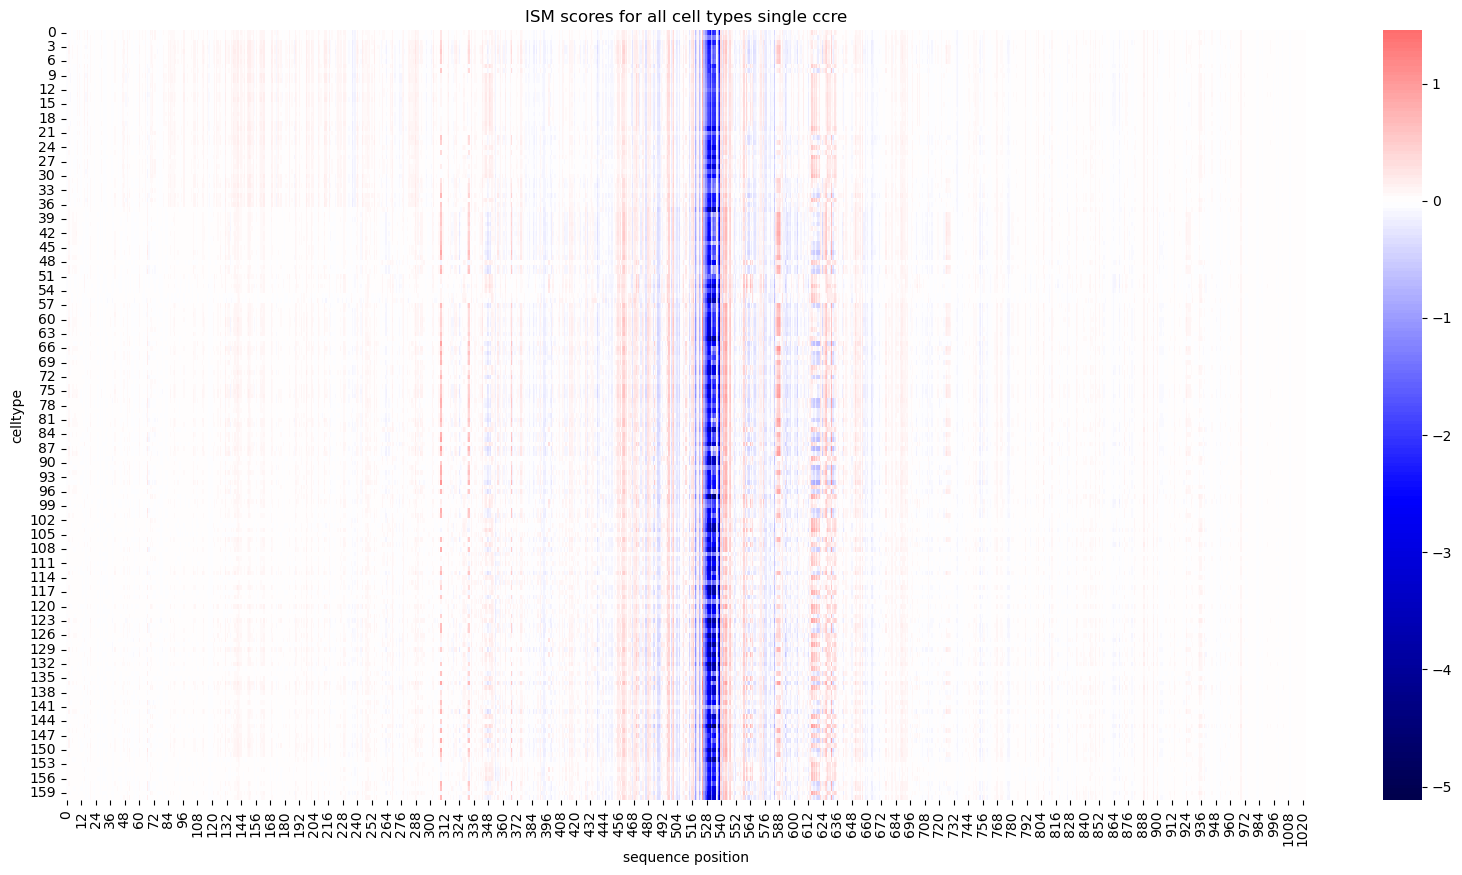

In [32]:
#let's plot it since this doesn't seem right at all
#if that doesn't work, we can artificially give a ton of copies of one celltype that clearly gives CTCF motif!
utils.plot_all(reg_out)

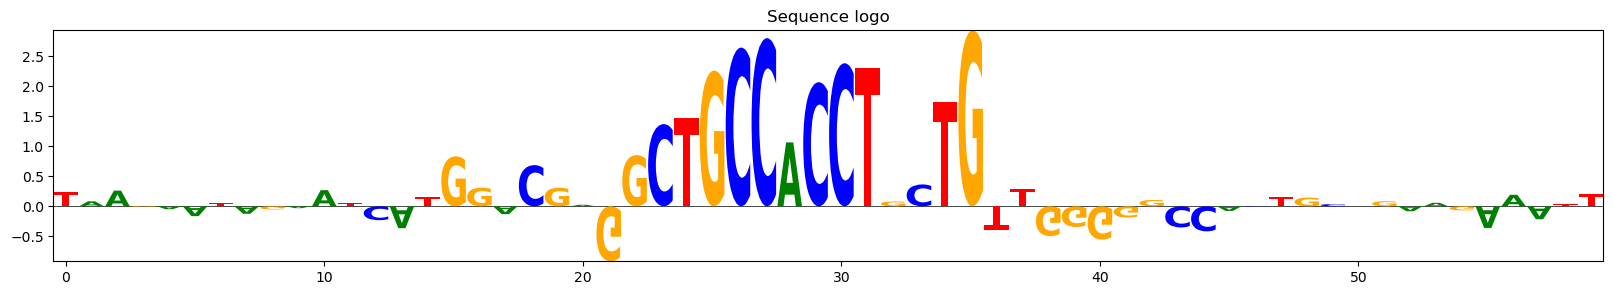

In [36]:
utils.logoplot(0, startend=[504,564], heights = utils.default_heights(reg_out), flip_heights=True)

In [37]:
#let's plot the ctcf motif

data = np.array(([0.095290,0.318729,0.083242,0.502738],
[0.182913,0.158817,0.453450,0.204819],
[0.307777,0.053669,0.491785,0.146769],
[0.061336,0.876232,0.023001,0.039430],
[0.008762,0.989047,0.000000,0.002191],
[0.814896,0.014239,0.071194,0.099671],
[0.043812,0.578313,0.365827,0.012048],
[0.117325,0.474781,0.052632,0.355263],
[0.933114,0.012061,0.035088,0.019737],
[0.005488,0.000000,0.991218,0.003293],
[0.365532,0.003293,0.621295,0.009879],
[0.059276,0.013172,0.553238,0.374314],
[0.013187,0.000000,0.978022,0.008791],
[0.061538,0.008791,0.851648,0.078022],
[0.114411,0.806381,0.005501,0.073707],
[0.409241,0.014301,0.557756,0.018702],
[0.090308,0.530837,0.338106,0.040749],
[0.128855,0.354626,0.080396,0.436123],
[0.442731,0.199339,0.292952,0.064978]))

In [38]:
data.shape

(19, 4)

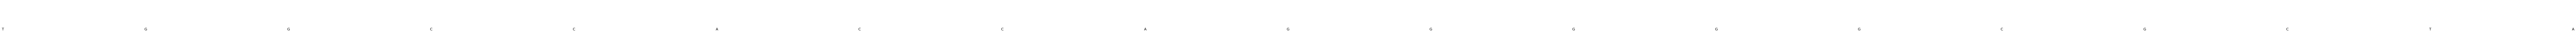

In [42]:
import matplotlib.pyplot as plt
nucleotides = ['A', 'C', 'G', 'T']

# Determine the most probable nucleotide at each position
max_indices = np.argmax(data, axis=1)
sequence = [nucleotides[i] for i in max_indices]

# Now, to plot. For a simple visualization, we'll just display the most frequent nucleotide
plt.figure(figsize=(10, 2))
for i, nt in enumerate(sequence):
    plt.text(i, 0, nt, fontsize=14, ha='center')

# Remove axes for clarity
plt.axis('off')
plt.show()

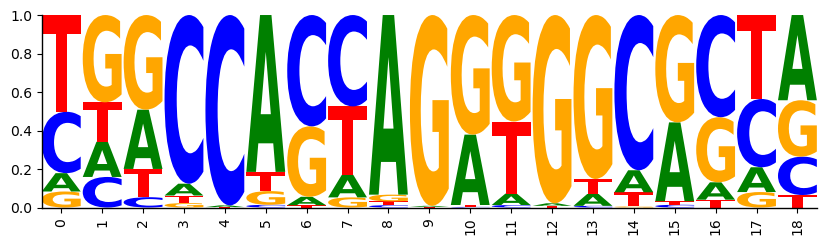

In [44]:
import logomaker
import numpy as np
import pandas as pd

# Your data as a numpy array
df = pd.DataFrame(data, columns=['A', 'C', 'G', 'T'])

# Use logomaker to create the logo plot
logo = logomaker.Logo(df, fade_below=0.5)

# Customize the logo plot as needed
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# Display the plot
logo.fig.show()


In [ ]:
#seems like we need a lot of G, 

# trying fimo instead of tfmodisco

In [1]:
#so first load in the sequence like before
import numpy as np
from shap_analysis.ism_utils import ISMUtils
multitasking_path1 = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-27/18-39-11-031863/checkpoints/25-val_loss=0.52186.ckpt' #the 25 epoch one
a = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train/multitasking_25epoch_174906_reg.npy')
utils = ISMUtils('DNase_allcelltypes', multitasking_path1, classification=True)
print(a.shape)
out = utils.onehot_ism(a)
print(len(out))

(4, 1023, 161)


IndexError: arrays used as indices must be of integer (or boolean) type

In [4]:
#now do it for cCRE 0 which we know is ctcf only
#let's get the one hot encoding values!
reg_out, class_out = utils.calculate_ISM(0, progress_bar=True) #this will jsut manually calculate the ISM values for the thing
#toclarify this is a terrible way to get the sequence, coudl just use the dataset and untokenize it

final3, one_hot_expanded3, seq3 = utils.onehot_ism(0, ism=reg_out)
print(seq3)

  0%|          | 0/1023 [00:00<?, ?it/s]

100%|██████████| 1023/1023 [01:58<00:00,  8.65it/s]

GGTGAAGGTAGAGAATCTGGTGGGGAAGCAAGCAAATGCCCATCACATGCACTTTCCTCCAACAGAGCGACTCAGATGCTATAAAACTTGCTAACACAGTCTCAGGGTCTGATCACAGTAACATACAATCCAGGTTTTAATCATCAGAAATCACAGTCCTATTGTCTTCTGCACAGACCCAAACACACTTGGAGGTCATGTTCAATATGAATACCTCACAGAGAAGGAAATTTACACGCGAGAAGTACATCTGCAGAAAGCCAGCTGGCATGTCAACCATTCAAAAACTCAGGGTGTTCTGGATAAAGAAGACTCAGGAAGACAAGTATGAAGCATAATCTGTGACATTCCATGCGGCAGACATTAGACACATACAAGAGAGTTGTTGGAAAGCGGAATTTATCTTCATATAAACAACACTGAGCTAAATCTCAATATTTCAGATCTCTAGAACTATCCATCAGTGAAATGGATTGCAAATACAAAGAGTAATACCATGTCACTTAAGAATAGAATCATGGACGAGGCTGCCACCTGCTGTTGGGGGCCACTGCAGAAGAAATTCCAGAACACTGGACTGGAGAGCACCTCACTTTCCTTACAGCTCTAAGTTTCTGACTCAGTGACCTGATTCACTACCATATACACAAAGACCCACTTACACAAATGACTGTTCTTCACACTAGGCCCATGGAGACAGGGATAAAATTCTGAATTTGCTCAGATACCTTCTCCGCTACTGACATCTAGGCATTACACAATTCATCTCTTCATATTTAACCTTTGAAGTTTGCTACTTCTCAGAGAGACTAATGAGTAGTGAGCAAATATCCTGAAGCTGAGAATGCTTCTACCTCCTCTCAAAACAACGGAATATTCATCAAAACACAGCAGTTCTGCACTTAACTTTAGGCCTTTTCTAACACCTTGTTTCTTGGCAGTAACTGTGGCCAGAATAGCTCTTTCCACAGATAAAGGACCTTTTGAAAGGATAGGGTCT

In [5]:
#actually that's a good test
a,b = utils.dataset[0]
print(a)

tensor([ 9,  9, 10,  ...,  8, 10,  8])


In [8]:
print(utils.dataset.tokenizer.decode(a))
print(utils.dataset.tokenizer.decode(a) == seq3)
print(len(seq3), len(a)) #ok it's exactly the same as we hoped

GGTGAAGGTAGAGAATCTGGTGGGGAAGCAAGCAAATGCCCATCACATGCACTTTCCTCCAACAGAGCGACTCAGATGCTATAAAACTTGCTAACACAGTCTCAGGGTCTGATCACAGTAACATACAATCCAGGTTTTAATCATCAGAAATCACAGTCCTATTGTCTTCTGCACAGACCCAAACACACTTGGAGGTCATGTTCAATATGAATACCTCACAGAGAAGGAAATTTACACGCGAGAAGTACATCTGCAGAAAGCCAGCTGGCATGTCAACCATTCAAAAACTCAGGGTGTTCTGGATAAAGAAGACTCAGGAAGACAAGTATGAAGCATAATCTGTGACATTCCATGCGGCAGACATTAGACACATACAAGAGAGTTGTTGGAAAGCGGAATTTATCTTCATATAAACAACACTGAGCTAAATCTCAATATTTCAGATCTCTAGAACTATCCATCAGTGAAATGGATTGCAAATACAAAGAGTAATACCATGTCACTTAAGAATAGAATCATGGACGAGGCTGCCACCTGCTGTTGGGGGCCACTGCAGAAGAAATTCCAGAACACTGGACTGGAGAGCACCTCACTTTCCTTACAGCTCTAAGTTTCTGACTCAGTGACCTGATTCACTACCATATACACAAAGACCCACTTACACAAATGACTGTTCTTCACACTAGGCCCATGGAGACAGGGATAAAATTCTGAATTTGCTCAGATACCTTCTCCGCTACTGACATCTAGGCATTACACAATTCATCTCTTCATATTTAACCTTTGAAGTTTGCTACTTCTCAGAGAGACTAATGAGTAGTGAGCAAATATCCTGAAGCTGAGAATGCTTCTACCTCCTCTCAAAACAACGGAATATTCATCAAAACACAGCAGTTCTGCACTTAACTTTAGGCCTTTTCTAACACCTTGTTTCTTGGCAGTAACTGTGGCCAGAATAGCTCTTTCCACAGATAAAGGACCTTTTGAAAGGATAGGGTCT

In [9]:
type(seq3) #just save the string out now

str

In [10]:
sequence_id = ">CTCFseq"

# Path to the output FASTA file
fasta_file_path = "/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/my_sequence.fasta"

# Writing to the FASTA file
with open(fasta_file_path, 'w') as fasta_file:
    fasta_file.write(f"{sequence_id}\n")
    fasta_file.write(f"{seq3}\n")

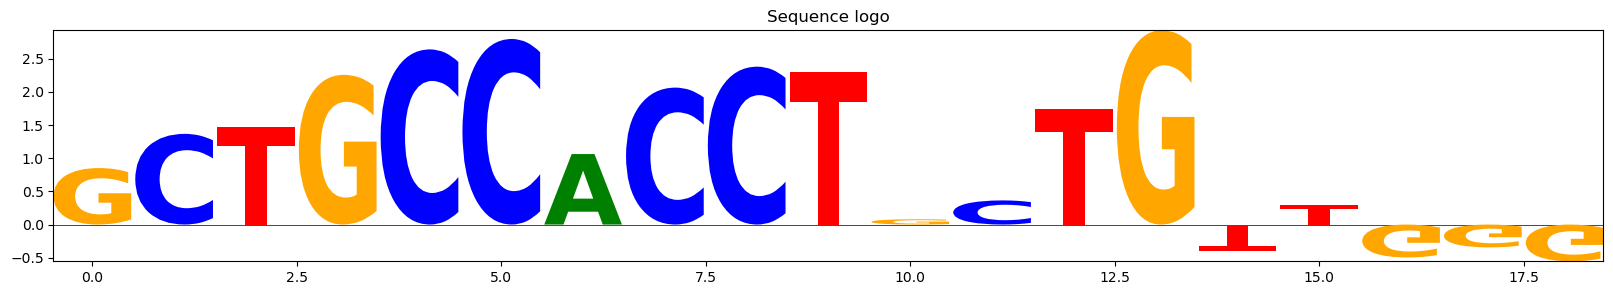

In [11]:
#now looking at the ISM plot, do 526 to 545
utils.logoplot(0, startend=[526,545], heights = utils.default_heights(reg_out), flip_heights=True)

In [12]:
#we have a html let's view it
from IPython.display import HTML
HTML('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/testing_modisco/fimo_test/fimo.html')

In [13]:
#let's ensure this sequence approach works by grabbing it from train.csv
a,b=utils.dataset[9034]
print(utils.dataset.tokenizer.decode(a))

TGTGTATCAGAGGCACCTGAGGTTTGCTTTCTGGCTCCACTTTGCCTGGGCCTCAAATGCCCCTTTTGTGAAGTGGGGCCAGGCTGGTTTGGGGTCCCTGATAGGCAGGAACCAGCCCAGGACACTTGAGTGCAGTAATGGGGCCTGGGCTTGGATTTGGGAGTAACCACCTGGCCAGCCAAACAACGATCTTTTTTTTGAGACGGAGTTTCACTCTTGTTGCCCAGGCTGGAGTACAATGGCGCAATCTCGGCTCACCACAACCTCTGCCTTCTGGGTTCAATAGATTTTCCTGCTTCAGCCTCCTGAATAGCTGGGATTACAGGCATGCACCACCACACCCAGCTAATTTTGTATTTTTAGTAGAGGTGGGGTTTCTCCATGTTGGTCAGGCTGGTCTCGAACTCCTGATCTCAGGTGATCTGCCCACCTTGGCCTCCCAAAGTGCTGGGATTACAGGTGTGAGCCACTGCGCCTGGCCCTCAAGCATCTCTTGAAGACCTGCCAGGAGGCACTGTGGGGACACCCAGGGAGGAGCCACAGTTTCTGTCCTCTGGGAGCTGACACGTGAGCAAGAGTGAGAACACAGGTTTAGGGGCTCCAGGACTGGGTTTGAATCTTGGGTCTTAGTAGCTGTGTGGTCTTGGGCAGGTGCCTTTGCCTTGCTCAGCCTTTGGGGCTCCCTCCAAAGATGGGAATAACAAGCCTTACTTCAGAGTGCATTGTGAGGCTAAAGTGAGATGGTGTCTGCAAAGCTCCCAGCACGTAGTAGGTGCTCAGTAAGGTGGTTTCCCCTGCCCAGAACCTCAGATGACTGTCTTCTAAGTCTGAGAGCAACCAGTGGGCCTCAAAGGCGATTGAGGGCTGCTTCCCCTGCCCTGCACCTCCCCCCCGCCCCGTCATGCTGGCAGCCCGGGAGCAGTCTCTCACGGTTCTGTGGGCAGCTGGAGATGGGGCAGAAGCGGGCGTCAGCTCCACAGTGGGGGCACTGGGAGGTGGG

In [14]:
#this is the output using 
#sed -n '9035p' train.csv
tempseq='TGTCCCCCTCTTCCCCCAGCTGATGGCCAAGGTAAGCAGGTGCCCTCCAGGGGAACGAGGTCACCTGCTTTGTGCCAGGTGATTGTACTGAATTCGCACCACTGTCCGGGGGCAGGGGCTGCTGTATCTATTTTACAGCAGAGGAGGAAACCAAGACATCAGGAGGAGGCCAGCTCGGTTTACACAGTTAATGAGAAATGGGCCTATGGCTAGAACCCAGGAGTGCCTCCCTGCAAAGTCCACACTTTCCCCACCTGGATCTCCAGCTGTCTCCTTGCTGTTAGGGTCACAAGGCAATGCTATGTGTATCAGAGGCACCTGAGGTTTGCTTTCTGGCTCCACTTTGCCTGGGCCTCAAATGCCCCTTTTGTGAAGTGGGGCCAGGCTGGTTTGGGGTCCCTGATAGGCAGGAACCAGCCCAGGACACTTGAGTGCAGTAATGGGGCCTGGGCTTGGATTTGGGAGTAACCACCTGGCCAGCCAAACAAcgatcttttttttgagacggagtttcactcttgttgcccaggctggagtacaatggcgcaatctcggctcaccacaacctctgccttctgggttcaatagattttcctgcttcagcctcctgaatagctgggattacaggcatgcaccaccacacccagctaattttgtatttttagtagaggtggggtttctccatgttggtcaggctggtctcgaactcctgatctcaggtgatctgcccaccttggcctcccaaagtgctgggattacaggtgtgagccactgcgcctggccctcaaGCATCTCTTGAAGACCTGCCAGGAGGCACTGTGGGGACACCCAGGGAGGAGCCACAGTTTCTGTCCTCTGGGAGCTGACACGTGAGCAAGAGTGAGAACACAGGTTTAGGGGCTCCAggactgggtttgaatcttgggtCTTagtagctgtgtggtcttgggcaggtGCCTTTGCCTTGCTCAGCCTTTGGGGCTCCCTCCAAAGATGGGAATAACAAGCCTTACTTCAGAGTGCA'

In [15]:
print(tempseq.upper() == utils.dataset.tokenizer.decode(a))
print(tempseq[:-1].upper() == utils.dataset.tokenizer.decode(a))

False
False


In [16]:
#of course it's false, remember, have to go one more into the thing, because first line is index 1, so want seq 9035, in python is 9034, in sed is 9036
#because indexing by 1 and line 1
tempseq = 'TGTGTATCAGAGGCACCTGAGGTTTGCTTTCTGGCTCCACTTTGCCTGGGCCTCAAATGCCCCTTTTGTGAAGTGGGGCCAGGCTGGTTTGGGGTCCCTGATAGGCAGGAACCAGCCCAGGACACTTGAGTGCAGTAATGGGGCCTGGGCTTGGATTTGGGAGTAACCACCTGGCCAGCCAAACAAcgatcttttttttgagacggagtttcactcttgttgcccaggctggagtacaatggcgcaatctcggctcaccacaacctctgccttctgggttcaatagattttcctgcttcagcctcctgaatagctgggattacaggcatgcaccaccacacccagctaattttgtatttttagtagaggtggggtttctccatgttggtcaggctggtctcgaactcctgatctcaggtgatctgcccaccttggcctcccaaagtgctgggattacaggtgtgagccactgcgcctggccctcaaGCATCTCTTGAAGACCTGCCAGGAGGCACTGTGGGGACACCCAGGGAGGAGCCACAGTTTCTGTCCTCTGGGAGCTGACACGTGAGCAAGAGTGAGAACACAGGTTTAGGGGCTCCAggactgggtttgaatcttgggtCTTagtagctgtgtggtcttgggcaggtGCCTTTGCCTTGCTCAGCCTTTGGGGCTCCCTCCAAAGATGGGAATAACAAGCCTTACTTCAGAGTGCATTGTGAGGCTAAAGTGAGATGGTGTCTGCAAAGCTCCCAgcacgtagtaggtgctcagtaaggtGGTTTCCCCTGCCCAGAACCTCAGATGACTGTCTTCTAAGTCTGAGAGCAACCAGTGGGCCTCAAAGGCGATTGAGGGCTGCTTCCCCTGCCCTGCACCTCCCCCCCGCCCCGTCATGCTGGCAGCCCGGGAGCAGTCTCTCACGGTTCTGTGGGCAGCTGGAGATGGGGCAGAAGCGGGCGTCAGCTCCACAGTGGGGGCACTGGGAGGTGGGGCCAGGCTTGactgggaggagagg'

In [18]:
print(tempseq.upper() == utils.dataset.tokenizer.decode(a))
print(tempseq[:-1].upper() == utils.dataset.tokenizer.decode(a)) #perfect, be careful on indexing
print(tempseq[:-1] == utils.dataset.tokenizer.deco)) #be careful about upper!

False
True
False
